In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.15.0


In [ ]:
import pyspark as spark

In [ ]:
# Импортируем SparkSession из pyspark.sql
from pyspark.sql import SparkSession

# Создаем объект SparkSession с именем spark
spark = SparkSession.builder \
    .appName("Taxi") \
    .getOrCreate() \



/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [ ]:
df = spark.read.csv("Taxi.csv", header=True, inferSchema=True)

In [ ]:
pandas_df = df.toPandas()
print(pandas_df.head())

   VendorID    tpep_pickup_datetime   tpep_dropoff_datetime  passenger_count  \
0       1.0  01/01/2020 12:28:15 AM  01/01/2020 12:33:03 AM              1.0   
1       1.0  01/01/2020 12:35:39 AM  01/01/2020 12:43:04 AM              1.0   
2       1.0  01/01/2020 12:47:41 AM  01/01/2020 12:53:52 AM              1.0   
3       1.0  01/01/2020 12:55:23 AM  01/01/2020 01:00:14 AM              1.0   
4       2.0  01/01/2020 12:01:58 AM  01/01/2020 12:04:16 AM              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0            1.2         1.0                  N           238         239.0   
1            1.2         1.0                  N           239         238.0   
2            0.6         1.0                  N           238         238.0   
3            0.8         1.0                  N           238         151.0   
4            0.0         1.0                  N           193         193.0   

   payment_type  fare_amount  extra  mta_tax

In [ ]:
pandas_df.isna().sum()

VendorID                 358
tpep_pickup_datetime       0
tpep_dropoff_datetime      0
passenger_count          358
trip_distance              0
RatecodeID               358
store_and_fwd_flag       358
PULocationID               0
DOLocationID               1
payment_type             359
fare_amount                1
extra                      1
mta_tax                    1
tip_amount                 1
tolls_amount               1
improvement_surcharge      1
total_amount               1
congestion_surcharge       1
dtype: int64

In [ ]:
dataset = pandas_df.dropna()

In [ ]:
dat = dataset[["total_amount", "tip_amount"]]
print(dat)

        total_amount  tip_amount
0              11.27        1.47
1              12.30        1.50
2              10.80        1.00
3               8.16        1.36
4               4.80        0.00
...              ...         ...
248341         14.16        2.36
248342         15.34        3.54
248343         11.63        2.33
248344         52.67        8.75
248345         32.75        5.45

[247988 rows x 2 columns]


In [ ]:
train_dataset = dat.sample(frac=0.8, random_state=0)
test_dataset = dat.drop(train_dataset.index)

print(train_dataset)
print(test_dataset)

        total_amount  tip_amount
52637          20.80        0.00
186104          6.80        0.00
110832         13.30        2.00
168516         13.55        2.25
183849          9.80        0.00
...              ...         ...
104434         12.96        2.16
103400         16.44        2.14
72519          46.42        4.00
58642          12.90        0.10
96294           6.80        0.00

[198390 rows x 2 columns]
        total_amount  tip_amount
2              10.80        1.00
10             17.55        1.75
21             27.35        4.55
27             12.80        0.00
30             10.30        0.00
...              ...         ...
248317         13.20        1.90
248318         10.80        0.00
248321         47.90        7.98
248330         13.55        2.25
248343         11.63        2.33

[49598 rows x 2 columns]


In [ ]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total_amount,198390.0,19.278632,16.224425,-207.3,10.8,14.15,20.76,465.3
tip_amount,198390.0,2.044663,3.213744,-7.0,0.0,1.56,2.75,450.0


In [ ]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
total_amount,19.278632,16.224425
tip_amount,2.044663,3.213744


In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('total_amount')
test_labels = test_features.pop('total_amount')

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[2.045]]


In [ ]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[0.]]

Normalized: [[-0.64]]


In [ ]:
horsepower = np.array(train_features['tip_amount'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [ ]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_12 (Normaliz  (None, 1)                 3         
 ation)                                                          
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5 (24.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [ ]:
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 0s 101ms/step


array([[ 1.053],
       [ 1.053],
       [ 0.023],
       [-0.106],
       [ 1.053],
       [-0.265],
       [-2.836],
       [-4.176],
       [-0.884],
       [ 1.053]], dtype=float32)

In [ ]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
%%time
history = horsepower_model.fit(
    train_features['tip_amount'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 14min 40s, sys: 49.8 s, total: 15min 30s
Wall time: 14min 22s


In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,6.661816,6.725159,95
96,6.662035,6.716369,96
97,6.660448,6.718278,97
98,6.661045,6.730134,98
99,6.660952,6.731279,99


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [total_amount]')
  plt.legend()
  plt.grid(True)

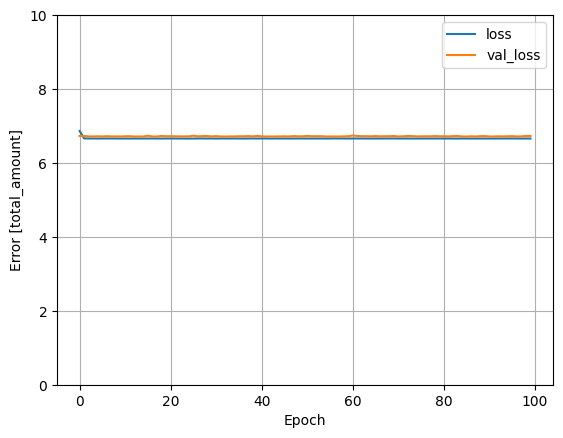

In [ ]:
plot_loss(history)

In [ ]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['tip_amount'],
    test_labels, verbose=0)

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 3ms/step


In [ ]:
def plot_horsepower(x, y):
  plt.scatter(train_features['tip_amount'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('tip_amount')
  plt.ylabel('total_amount')
  plt.legend()

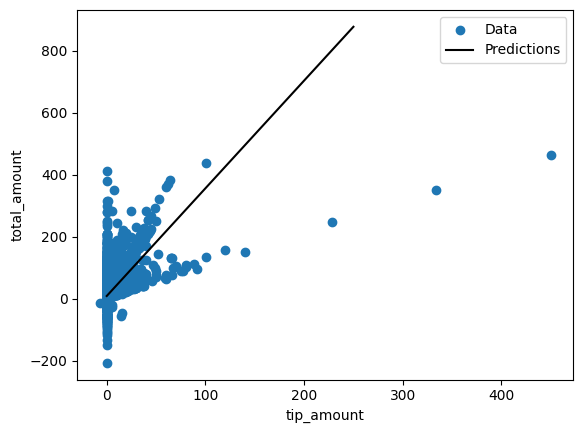

In [ ]:
plot_horsepower(x, y)

In [ ]:
# Остановка SparkSession после завершения работы
spark.stop()